In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import imageio
import os
from tqdm import tqdm

In [2]:
torch.cuda.is_available()
x = torch.tensor(90.00, requires_grad=True)
x_mom = torch.tensor(90.00, requires_grad=True)
x_ad = torch.tensor(90.00, requires_grad=True)
x_rms = torch.tensor(90.00, requires_grad=True)
x_adagrad = torch.tensor(90.00, requires_grad=True)
y = torch.tensor(95.00, requires_grad=True)
y_mom = torch.tensor(95.00, requires_grad=True)
y_ad = torch.tensor(95.00, requires_grad=True)
y_rms = torch.tensor(95.00, requires_grad=True)
y_adagrad = torch.tensor(95.00, requires_grad=True)

In [3]:
x.dtype

torch.float32

In [4]:
# define your own loss function
def loss_function(x, y):
    return 10*x*x + y*y

In [5]:
# run your backpropagation for certain epochs
opt = optim.SGD([x, y], lr=0.01)
opt_mom = optim.SGD([x_mom, y_mom], lr=0.01, momentum=0.9)
opt_ad =optim.Adam([x_ad, y_ad], lr=0.2)
opt_rms = optim.RMSprop([x_rms, y_rms], lr=0.3)
opt_adagrad = optim.Adagrad([x_adagrad, y_adagrad], lr=0.8)

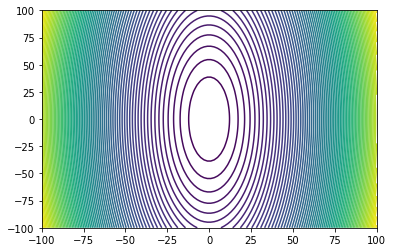

In [6]:
## PLot the contorur of the loss function
x1 = np.linspace(-100, 100, 100)
x2 = np.linspace(-100, 100, 100)
X1, X2 = np.meshgrid(x1, x2)
Z = 10*X1*X1 + X2*X2
plt.contour(X1, X2, Z, 100)

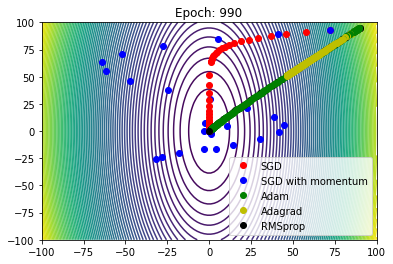

In [7]:
x1 = np.linspace(-100, 100, 100)
x2 = np.linspace(-100, 100, 100)
X1, X2 = np.meshgrid(x1, x2)
Z = 10*X1*X1 + X2*X2
plt.contour(X1, X2, Z, 100)
filenames = []
for epoch in range(1000):
    opt.zero_grad()
    opt_mom.zero_grad()
    opt_ad.zero_grad()
    opt_adagrad.zero_grad()
    opt_rms.zero_grad()
    
    loss = loss_function(x, y)
    loss_mom = loss_function(x_mom, y_mom)
    loss_ad = loss_function(x_ad, y_ad)
    loss_adagrad = loss_function(x_adagrad, y_adagrad)
    loss_rms = loss_function(x_rms, y_rms)
    if(epoch%10==0 or epoch < 20):
        plt.plot([x.item()], [y.item()], 'ro')
        plt.plot([x_mom.item()], [y_mom.item()], 'bo')
        plt.plot([x_ad.item()], [y_ad.item()], 'go')
        plt.plot([x_adagrad.item()], [y_adagrad.item()], 'yo')
        plt.plot([x_rms.item()], [y_rms.item()], 'ko')
        filenames.append('Figures/frame{:03d}.png'.format(epoch))
        plt.legend(['SGD', 'SGD with momentum', 'Adam', 'Adagrad', 'RMSprop'])
        plt.title('Epoch: {}'.format(epoch))
        plt.savefig(filenames[-1])
    loss.backward()
    loss_mom.backward()
    loss_adagrad.backward()
    loss_rms.backward()
    loss_ad.backward()
    opt.step()
    opt_mom.step()
    opt_ad.step()
    opt_adagrad.step()
    opt_rms.step()


In [8]:
with imageio.get_writer('movie.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.v2.imread(filename)
        writer.append_data(image)

<img src="movie.gif" width="350" align="center">

In [9]:
for filename in set(filenames):
    os.remove(filename)